In [2]:
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import datasets, layers, models, metrics
import matplotlib.pyplot as plt

# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

/Users/grayson/anaconda3/envs/tf_env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
from PIL import Image

#run this if images are not saved locally as np array

#in order for this to work, you need to download the data from kaggle as a zip and upload it to the following directory:
# /content/drive/MyDrive/CS3540/CS3540-Assignments/final-project/data/

glioma_path = 'data/Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma'
menin_path = 'data/Brain_Cancer raw MRI data/Brain_Cancer/brain_menin'
tumor_path = 'data/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor'

image_data = []
image_labels = []

target_size = (224, 224) # this is a hyper param, rescaled size of images that will be used as the input shape for the CNN



for directory_path in [glioma_path, menin_path, tumor_path]:
    if os.path.exists(directory_path):
        label = os.path.basename(directory_path) # directory corresponds to label
        for filename in os.listdir(directory_path):
            full_path = os.path.join(directory_path, filename)
            if os.path.isfile(full_path):
                try:
                    img = Image.open(full_path).convert('RGB')
                    img_resized = img.resize(target_size) # <- we resize so the image data isn't incredibly huge but still provides enough information to train on
                    img_array = np.asarray(img_resized)
                    image_data.append(img_array)
                    image_labels.append(label)
                except Exception as e:
                    print(f"Error processing {full_path}: {e}")
    else:
        print(f"Directory not found: {directory_path}")

# Convert the lists to numpy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print("Image data shape:", image_data.shape)
print("Image labels shape:", image_labels.shape)
print("Example labels:", image_labels[:10])

Image data shape: (6056, 224, 224, 3)
Image labels shape: (6056,)
Example labels: ['brain_glioma' 'brain_glioma' 'brain_glioma' 'brain_glioma'
 'brain_glioma' 'brain_glioma' 'brain_glioma' 'brain_glioma'
 'brain_glioma' 'brain_glioma']


In [4]:
# Save the image data and labels
# only run this cell if generating images for the first time after running the above cell
np.save('data/image_data_224.npy', image_data)
np.save('data/image_labels_224.npy', image_labels)

print("Image data and labels saved as 'image_data_224.npy' and 'image_labels_224.npy'")

Image data and labels saved as 'image_data_224.npy' and 'image_labels_224.npy'


In [5]:
# load image data, if saved locally

image_data = np.load('data/image_data_224.npy')
image_labels = np.load('data/image_labels_224.npy')

In [6]:
# Normalize the image data

# run this cell after images have either been loaded or generated in the above cell
for image in image_data:
  image = image / 255

print("Image data normalized.")

Image data normalized.


In [7]:
class_names = ['glioma', 'menin', 'tumor']

x_train, x_test, y_train, y_test = train_test_split(image_data, image_labels, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Data split into training and testing sets.
X_train shape: (4844, 224, 224, 3)
X_test shape: (1212, 224, 224, 3)
y_train shape: (4844,)
y_test shape: (1212,)


In [8]:
#run this cell to change image labels to ints (CNN wants this and won't work without it)

# change labels from strings to int

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the string labels to integer labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Update y_train and y_test to use the encoded labels
y_train = y_train_encoded
y_test = y_test_encoded

In [54]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_22[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [55]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(1024, activation='gelu')
dense_layer_2 = tf.keras.layers.Dense(512, activation='gelu')
prediction_layer = tf.keras.layers.Dense(len(class_names), activation = 'softmax')
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [56]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dense_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = dense_layer_2(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [57]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [58]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(x_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.4662 - loss: 1.0507


Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.7777 - loss: 0.5287 - val_accuracy: 0.8820 - val_loss: 0.3293
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.8666 - loss: 0.3395 - val_accuracy: 0.9175 - val_loss: 0.2525
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.8891 - loss: 0.2825 - val_accuracy: 0.9092 - val_loss: 0.2600
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.9036 - loss: 0.2411 - val_accuracy: 0.9282 - val_loss: 0.2010
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.9118 - loss: 0.2394 - val_accuracy: 0.9216 - val_loss: 0.2219
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.9211 - loss: 0.2052 - val_accuracy: 0.9389 - val_loss: 0.1944
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.9230 - loss: 0.1968 - val_accuracy: 0.9084 - val_loss: 0.2488
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.9300 - loss: 0.1874 -

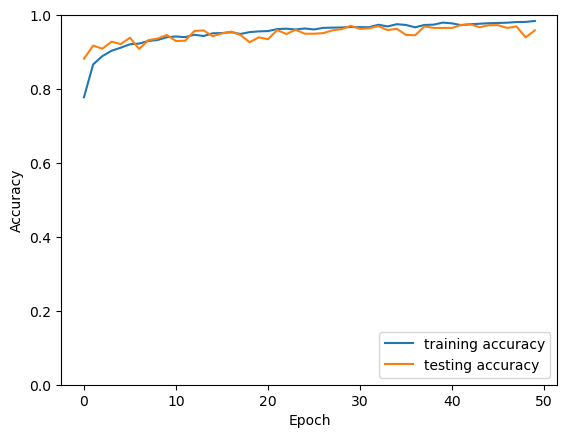

In [59]:
history = model.fit(x_train, y_train, epochs=initial_epochs,
                    validation_data=(x_test, y_test))


plt.plot(history.history['accuracy'], label='training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

checkpoint_path = "transfer_learning_checkpoints.weights.h5"
model.save_weights(checkpoint_path)

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)


print("accuracy on test dataset: ", test_acc)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step


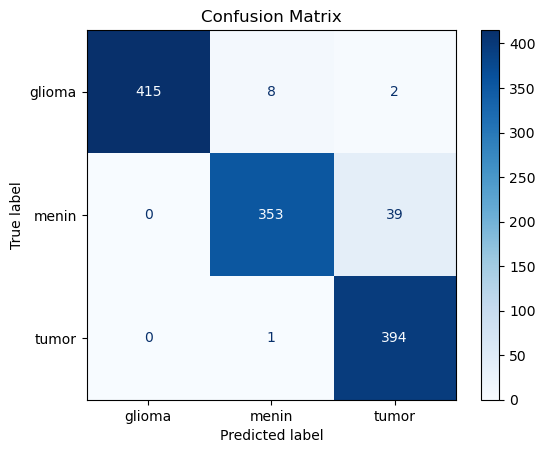

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       425
       menin       0.98      0.90      0.94       392
       tumor       0.91      1.00      0.95       395

    accuracy                           0.96      1212
   macro avg       0.96      0.96      0.96      1212
weighted avg       0.96      0.96      0.96      1212



In [61]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Make predictions on the test data
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test_encoded, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)